In [1]:
import re

In [2]:
filename='data/AFD_Wahlprogramm_2021.txt'

In [53]:
with open(filename) as f:
    text = f.read()
    #text = text.replace(r'\\d+\\n', '$')
    #text=   re.sub("\n\n", ".", text)
    #text=   re.sub("\d+.", ".", text)
    text=   re.sub(" \d+\n", ".", text)
    text=   re.sub("\n\d+", " ", text)
    text=   re.sub("\n", " ", text)
sentences = re.split(r' *[\.\?!][\'"\)\]]* *', text)

In [4]:
import yaml
import pandas as pd

DATA_DIR = "data"


def load_yaml_file(file_path):
    # reads the yml files as a dictionary, were each topic is a key and the values are a list of elements
    with open(file_path, "r") as stream:
        yaml_dict = yaml.safe_load(stream)
        return yaml_dict


def load_markdown_file(file_path):
    with open(file_path, "r") as stream:
        markdown_str = stream.read()
        return markdown_str


def get_counts(df: pd.DataFrame, label_col: str = "label") -> pd.DataFrame:
    """
    Get the labels count in a dataframe.
   
    """
    count_df = df[label_col].value_counts().to_frame().reset_index()
    count_df.columns = [label_col, "sentence_count"]
    count_df["percent"] = count_df.sentence_count / count_df.sentence_count.sum() * 100
    return 

In [78]:
from typing import Dict, List
import spacy
from string import punctuation
import pandas as pd
from tqdm.auto import tqdm
from transformers import pipeline


def _add_sentence_to_list(sentence: str, sentences_list):
    """
    Add a sentence to the list of sentences.
    Args:
        sentence (str):
            Sentence to be added.
        sentences (List[str]):
            List of sentences.
    """
    while sentence.startswith(" "):
        # remove leading space
        sentence = sentence[1:]
    if all(c in punctuation for c in sentence) or len(sentence) == 1:
        # skip sentences with only punctuation
        return
    sentences_list.append(sentence)


def get_sentences(text: str):
    """
    Get sentences from a text.
    Args:
        text (str):
            Text to be processed.
    Returns:
        List[str]:
            List of sentences.
    """
    # get the paragraphs
    text=   re.sub(" \d+\n", ".", text)
    text=   re.sub("\n\d+", " ", text)
    text=   re.sub("\n", " ", text)
    text=   re.sub("\d+.", "", text)
    paragraphs = re.split(r' *[\.\?!][\'"\)\]]* *', text)
    paragraphs = [p for p in paragraphs if p != ""]
    # get the sentences from the paragraphs
    sentences = list()
    for paragraph in paragraphs:
        if paragraph.startswith("#"):
            _add_sentence_to_list(paragraph, sentences)
            continue
        prev_sentence_idx = 0
        for idx in range(len(paragraph)):
            if idx + 1 < len(paragraph):
                if (paragraph[idx] == "." and not paragraph[idx + 1].isdigit()) or (
                    paragraph[idx] in "!?"
                ):
                    sentence = paragraph[prev_sentence_idx : idx + 1]
                    _add_sentence_to_list(sentence, sentences)
                    prev_sentence_idx = idx + 1
            else:
                sentence = paragraph[prev_sentence_idx:]
                _add_sentence_to_list(sentence, sentences)
    return sentences


def get_words(text: str) -> List[str]:
    """
    Get every word in the text that isn't a stopword or punctuation,
    and that is either a noun, adjective, verb or interjection
    """
    nlp = spacy.load("de_core_news_lg")
    nlp.max_length = 8000000
    doc = nlp(text)
    words = [
        word.text.replace("\n", "").replace("*", "")  # remove new line and bold symbols
        for word in doc
        if not word.is_stop  # remove stopwords
        and not word.is_punct  # remove punctuation
        and (
            word.pos_ == "NOUN"  # noun
            or word.pos_ == "ADJ"  # adjective
            or word.pos_ == "VERB"  # verb
            or word.pos_ == "INTJ"  # interjection
            or word.pos_ == "X"  # other
        )
    ]
    # remove blank words and spaces
    words = [word for word in words if word != ""]
    words = [word.replace(" ", "") for word in words]
    # make all words lowercase
    words = [word.lower() for word in words]
    # remove undesired words
    words = [
        word
        for word in words
        if word not in [ "Politik","Politiker"]
    ]
    # remove words with less than 3 characters
    words = [word for word in words if len(word) > 2]
    return words


def get_topical_sentences(
    sentences, topics, df_y=0
) :

    "classifies the content based on the frequency of the occurring words of the classes"
    sent_df=[]
    topical_sentences = dict()
    topics_list=[]
    for topic in topics:
        topics_list.append(topic)
        topical_sentences[topic] = list()
        #topical_sentences[f'{topic}_num'] = list()
    for sentence in sentences:
        topic_list=[]
        for topic in topics:
            if any(str(topical_word) in str(sentence.lower()) for topical_word in topics[topic]):
                for  topical_word in topics[topic]:
                        if str(topical_word) in str(sentence.lower()):
                            topic_num+=1
                
                
            else:
                topic_num=0
            topic_list.append(topic_num)
        
        topical_sentences[topics_list[max(range(len(topic_list)), key=topic_list.__getitem__)]].append(sentence)
        if df_y:
            sent_df.append([sentence,topics_list[max(range(len(topic_list)), key=topic_list.__getitem__)]])
    if df_y:
        return pd.DataFrame(data=sent_df,columns=['text','topic'])

    return topical_sentences




In [51]:
lsit=[1,2,3,8,2,5]
lsit[max(range(len(lsit)), key=lsit.__getitem__)]

8

In [52]:
from typing import Dict, List
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.graph_objects import Figure
import os
import pandas as pd



def get_word_cloud(
    words: List[str],
    max_words: int = 500,
    image_path: str = None,
    image_name: str = None,
):
    """
    Create a word cloud based on a set of words.
    """
    # change the value to black
    def black_color_func(
        word, font_size, position, orientation, random_state=None, **kwargs
    ):
        return "hsl(0,100%, 1%)"

    # set the wordcloud background color to white
    # set width and height to higher quality, 3000 x 2000
    wordcloud = WordCloud(
        font_path="/Library/Fonts/Arial Unicode.ttf",
        background_color="white",
        width=3000,
        height=2000,
        max_words=max_words,
    ).generate(" ".join(words))
    # set the word color to black
    wordcloud.recolor(color_func=black_color_func)
    # set the figsize
    plt.figure(figsize=[15, 10])
    # plot the wordcloud
    plt.imshow(wordcloud, interpolation="bilinear")
    # remove plot axes
    plt.axis("off")
    if image_path is not None and image_name is not None:
        # save the image
        plt.savefig(os.path.join(image_path, image_name), bbox_inches="tight")


def plot_topical_presence(
    sentences: List[str],
    topics: Dict[str, List[str]],
    title: str = None,
    color: str = "blue",
    height: int = 300,
) :
    """
    Plot the number of sentences per topic.
    """
    topical_sentences = get_topical_sentences(sentences, topics)
    topic_sentence_count = dict()
    for topic in topical_sentences.keys():
        topic_sentence_count[topic] = len(topical_sentences[topic])
    topic_sentence_count = pd.DataFrame(
        topic_sentence_count, index=["sentence_count"]
    ).T
    topic_sentence_count["sentence_percentage"] = (
        topic_sentence_count["sentence_count"] / len(sentences) * 100
    )
    topic_sentence_count.index.name = "topic"
    topic_sentence_count.sort_index(inplace=True)
    fig = px.bar(topic_sentence_count, x="sentence_percentage", orientation="h")
    fig.update_layout(
        title=title,
        xaxis_title="Prozent",
        yaxis_title="Topic",
        yaxis=dict(categoryorder="category descending"),
        margin=dict(l=0, r=0, b=0, t=0, pad=0),
        height=height,
    )
    fig.update_traces(marker_color=color)
    return fig


def plot_approaches(
    sentences: List[str],
    approaches: Dict[str, List[str]],
    title: str = None,
    height: int = 300,
):
    """
    Plot the approaches taken to language and policy.
    """
    approach_sentences = get_topical_sentences(sentences, approaches)
    approach_sentence_count = dict()
    total_num_sentences_in_approaches = sum(
        [len(approach_sentences[approach]) for approach in approach_sentences.keys()]
    )
    for approach in approaches:
        approach_sentence_count[approach] = (
            len(approach_sentences[approach]) / total_num_sentences_in_approaches * 100
        )
    fig = go.Figure()
    fig.add_trace(
        go.Bar(
            x=[approach_sentence_count["rational"]],
            name="rational",
            orientation="h",
            marker=dict(color="green"),
            hovertemplate="rational: %{x:.1f}%<extra></extra>",
        )
    )
    fig.add_trace(
        go.Bar(
            x=[approach_sentence_count["Intuitionen"]],
            name="intuition",
            orientation="h",
            marker=dict(color="red"),
            hovertemplate="intuition: %{x:.1f}%<extra></extra>",
        )
    )
    fig.update_layout(
        title=title,
        barmode="stack",
        xaxis=dict(
            showgrid=False,  # thin lines in the background
            zeroline=False,  # thick line at x=0
            visible=False,  # numbers below
        ),
        yaxis=dict(
            showgrid=False,  # thin lines in the background
            zeroline=False,  # thick line at x=0
            visible=False,  # numbers below
        ),
        margin=dict(l=0, r=0, b=0, t=0, pad=0),
        height=height,
    )
    return fig


def plot_sentiment(
    df: pd.DataFrame, title: str = None, height: int = 300, label_col: str = "label"
):
    """
    Plot the predicted sentiment of the sentences.
    """
    sentiments_count = get_counts(df, label_col=label_col)
    labels_order = ["neutral", "positiv", "negativ"]
    fig = px.bar(
        x=labels_order,
        y=[
            float(sentiments_count[sentiments_count[label_col] == label].percent)
            for label in labels_order
        ],
        title=title,
    )
    fig.update_traces(
        marker_color=["gray", "green", "red"],
        hovertemplate="%{y:.1f}%<extra></extra>",
    )
    fig.update_layout(
        xaxis_title="Sntiment",
        yaxis_title="Prozent",
        margin=dict(l=0, r=0, b=0, t=0, pad=0),
        height=height,
    )
    return fig


def plot_hate_speech(
    df: pd.DataFrame, title: str = None, height: int = 300, label_col: str = "label"
) :
    """
    Show the percentage of estimated hate speech sentences.
    """
    hate_count = get_counts(df, label_col=label_col)
    try:
        hate_percent = hate_count[hate_count[label_col] == "negativ"].percent.values[0]
    except IndexError:
        hate_percent = 0
    fig = go.Figure(
        go.Indicator(
            mode="number",
            value=hate_percent,
            title=title,
            number=dict(suffix="%", valueformat=".2f"),
            delta=dict(position="top", reference=320),
            domain=dict(x=[0, 1], y=[0, 1]),
        )
    )
    fig.update_layout(
        paper_bgcolor="darkred",
        font_color="white",
        margin=dict(l=0, r=0, b=0, t=0, pad=0),
        height=height,
    )
    return fig

In [8]:
import os
import sys
from ipywidgets import interact
import plotly.io as pio
from string import punctuation

In [9]:
pio.templates.default = "plotly_white"
data_name = None
party_data = None
party_names = None
selected_party = None

In [10]:
DATA_DIR='data'

In [11]:
data_names = os.listdir(DATA_DIR)
data_names = [name[:-4] for name in data_names if name != ".DS_Store"]

In [12]:
data_names

['DIE_GRUENEN_Wahlprogramm_2021',
 'FDP_Wahlprogramm_2021',
 'DIE_LINKE_Wahlprogramm_2021',
 'CDU-CSU_Wahlrprogramm_2021',
 '',
 'SPD_Wahlprogramm_2021',
 'AFD_Wahlprogramm_2021']

In [13]:
@interact
def set_data(data=data_names):
    global data_name
    global party_data
    global party_names
    data_name = data
    party_data = load_yaml_file('topic_modeling/paties.yml')
    party_names = list(party_data.keys())

interactive(children=(Dropdown(description='data', options=('DIE_GRUENEN_Wahlprogramm_2021', 'FDP_Wahlprogramm…

In [14]:
@interact
def select_party(party=party_names):
    global selected_party
    selected_party = party

interactive(children=(Dropdown(description='party', options=('AFD', 'CDU', 'GR', 'LI', 'FDP', 'SPD'), value='A…

In [15]:
party_names

['AFD', 'CDU', 'GR', 'LI', 'FDP', 'SPD']

In [16]:
topics = load_yaml_file('topic_modeling/topic_g.yml')
topics.keys()


dict_keys(['wirtschaft', 'Klima', 'Bildung', 'Gesundheit', 'Wissenschaft', 'soziale Ursachen', 'Politik und Ideologie', 'Infrastruktur'])

In [17]:
topics['wirtschaft'][0:5]


['Steuer', 'Steuerarten', 'Einkommensteuer', 'Finanzierung', 'Finanzen']

In [18]:
' '.join(topics['wirtschaft'][0:8])

'Steuer Steuerarten Einkommensteuer Finanzierung Finanzen Wirtschaft Volkswirtschaft Marktwirtschaft'

In [19]:
def list_lemma(lsit):
    liste=[]
    string=' '.join(lsit)
    nlp = spacy.load("de_core_news_lg")
    doc = nlp(str(string))
    for token in tqdm(doc):
        if not token.is_stop and not token.is_punct:
            liste.append(token.lemma_.lower())
    return list(dict.fromkeys(liste))  

In [20]:
list_lemma(topics['wirtschaft'])

  0%|          | 0/319 [00:00<?, ?it/s]

['steuer',
 'steuerart',
 'einkommensteuer',
 'finanzierung',
 'finanz',
 'wirtschaft',
 'volkswirtschaft',
 'marktwirtschaft',
 'planwirtschaft',
 'sozial',
 'kapitalismus',
 'kommunismus',
 'sozialismus',
 'bip',
 'inflation',
 'arbeitslosigkeit',
 'zins',
 'aktienmarkt',
 'wechselkurs',
 'handel',
 'zölle',
 'schutzzölle',
 'freihandel',
 'outsourcing',
 'angebot',
 'nachfrage',
 'konsum',
 'investition',
 'sparen',
 'kredit',
 'schuld',
 'defizit',
 'überschuss',
 'haushaltspolitik',
 'geldpolitik',
 'inflationsziel',
 'quantitative',
 'lockerung',
 'haushaltsdefizit',
 'haushaltsüberschuss',
 'haushalt',
 'lehrling',
 'betrag',
 'einnahme',
 'ausgabe',
 'staatsausgabe',
 'leistungsprogramme',
 'sozialversicherung',
 'krankenversicherung',
 'arm',
 'sozialhilfe',
 'arbeitslosenversicherung',
 'pension',
 'rente',
 'sparbuch',
 'festgeld',
 'geldmarktkonto',
 'bank',
 'kreditunion',
 'hypothek',
 'schuldenkonsolidierung',
 'schufa',
 'e-commerce',
 'online-shopping',
 'betrug',
 'ge

In [21]:
for topic in topics.keys():
    topics[topic]=list_lemma(topics[topic])

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

In [22]:
topics['wirtschaft'][0:10]

['steuer',
 'steuerart',
 'einkommensteuer',
 'finanzierung',
 'finanz',
 'wirtschaft',
 'volkswirtschaft',
 'marktwirtschaft',
 'planwirtschaft',
 'sozial']

In [23]:
approaches = load_yaml_file(os.path.join('topic_modeling', "approaches.yml"))
approaches.keys()

dict_keys(['rational', 'Intuitionen'])

In [24]:
data_name

'DIE_GRUENEN_Wahlprogramm_2021'

In [25]:
program_txt = load_markdown_file(os.path.join(DATA_DIR, f"{data_name}.txt"))


In [26]:
program_txt[:100]


'IEITTESALTENTR\nAlles ist drin.\n\nBundestagswahlprogramm 2021\n\nBereit, weil Ihr es seid.\n\nDieses Bunde'

In [27]:
sentences = get_sentences(program_txt)


In [28]:
sentences[0:10]

['IEITTESALTENTR Alles ist drin',
 'Bundestagswahlprogramm',
 'Bereit, weil Ihr es seid',
 'Dieses Bundestagswahlprogramm wurde auf der  Bundesdelegiertenkonferenz von BÜNDNIS DIE GRÜNEN beschlossen, die vom bis  Juni digital stattgefunden hat',
 'Herausgeberin:  BÜNDNIS DIE GRÜNEN Platz vor dem Neuen Tor',
 'Berlin  Telefon:  Fax: E-Mail: info@gruene',
 'de Internet: gruene',
 'de  V',
 ':  BÜNDNIS DIE GRÜNEN Annkathrin Schäfer  Platz vor dem Neuen Tor',
 'Berlin  Layout und Satz: Twentyfour Seven Creative Media Service GmbH, Berlin twentyfour-/']

In [29]:
def text_lemma(lsit):
    liste=[]
    nlp = spacy.load("de_core_news_lg",disable=['parser', 'ner','tagger'])
    doc = nlp(lsit)
    for token in doc:
        if not token.is_stop and not token.is_punct:
            liste.append(token.lemma_.lower())

    return ' '.join(liste)

In [31]:
sent=[]
for text in tqdm(sentences):
    sent.append(text_lemma(text))

  0%|          | 0/4880 [00:00<?, ?it/s]

In [32]:
sent[0]

'ieittesaltentr'

In [33]:
with open(r'data/sent/sent.txt', 'w') as fp:
    for item in sent:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


In [34]:
sent[0:10]

['ieittesaltentr',
 'bundestagswahlprogramm',
 'bereit',
 'bundestagswahlprogramm   bundesdelegiertenkonferenz bündnis grünen beschließen   juni digital stattfinden',
 'herausgeberin   bündnis grünen platz tor',
 'berlin   telefon   fax e-mail info@gruener',
 'de internet gruene',
 '--   v',
 '  bündnis grünen annkathrin schäfer   platz tor',
 'berlin   layout satz twentyfour seven creative media service gmbh berlin twentyfour-']

In [35]:
words = get_words(' '.join(sent))

In [36]:
words[:10]


['bundestagswahlprogramm',
 'bundestagswahlprogramm',
 'bundesdelegiertenkonferenz',
 'bündnis',
 'grünen',
 'beschließen',
 'juni',
 'stattfinden',
 'herausgeberin',
 'bündnis']

get words --Spacy pipline  --> grundform erstelle n--> wieder zu sätzen machen und diese dann auf inhalte analysieren 

In [37]:
[w for w in words if any(p in w for p in punctuation)]


['e-mail',
 'info@gruener',
 'twentyfour-',
 'sozial-',
 'sozial-öökologische',
 'globa-',
 'sozial-ökologische',
 'bür-',
 'sys-',
 'kur-',
 'demo-',
 'kommu-',
 'sozial-oko-',
 'klima-',
 'grad-',
 'ent-',
 'ver-',
 'schaf-',
 'klima-',
 'sozial-ökologi-',
 'plane-',
 'tra-',
 'wer-',
 'naturver-',
 'beizutra-',
 'notstrom-',
 'schaf-',
 'sozial-ökologische',
 'plane-',
 'corona-krise',
 'zukunftstechno-',
 'rebound-effekt',
 'it-',
 'it-produkt',
 'einset-',
 'schaf-',
 'sozial-ökologisch',
 'wettbewerbs-',
 'bau-',
 'qualifizierungs-kurzarbeitergeld',
 'ökolo-',
 'qualifizierungs-kurzarbeitergeld',
 'unterneh-',
 'qualifizierungs-kurz',
 'blei-',
 'wirt-',
 'gemein-',
 'klimaschutz-sofortprogramm',
 'koh-',
 'co,-budget',
 '-prozentig',
 'co,-budget',
 'klimaschutz-sofortprogramm',
 'beste-',
 'klima-und',
 'generationen-',
 'budget-',
 'jahres-',
 'güns-',
 'unweiger-',
 'eu-emissionshandelssystem',
 'eu-klimaziel',
 'deut-',
 'co;-preis',
 'co;-preis',
 'co;-',
 'co;-preis',
 'ee

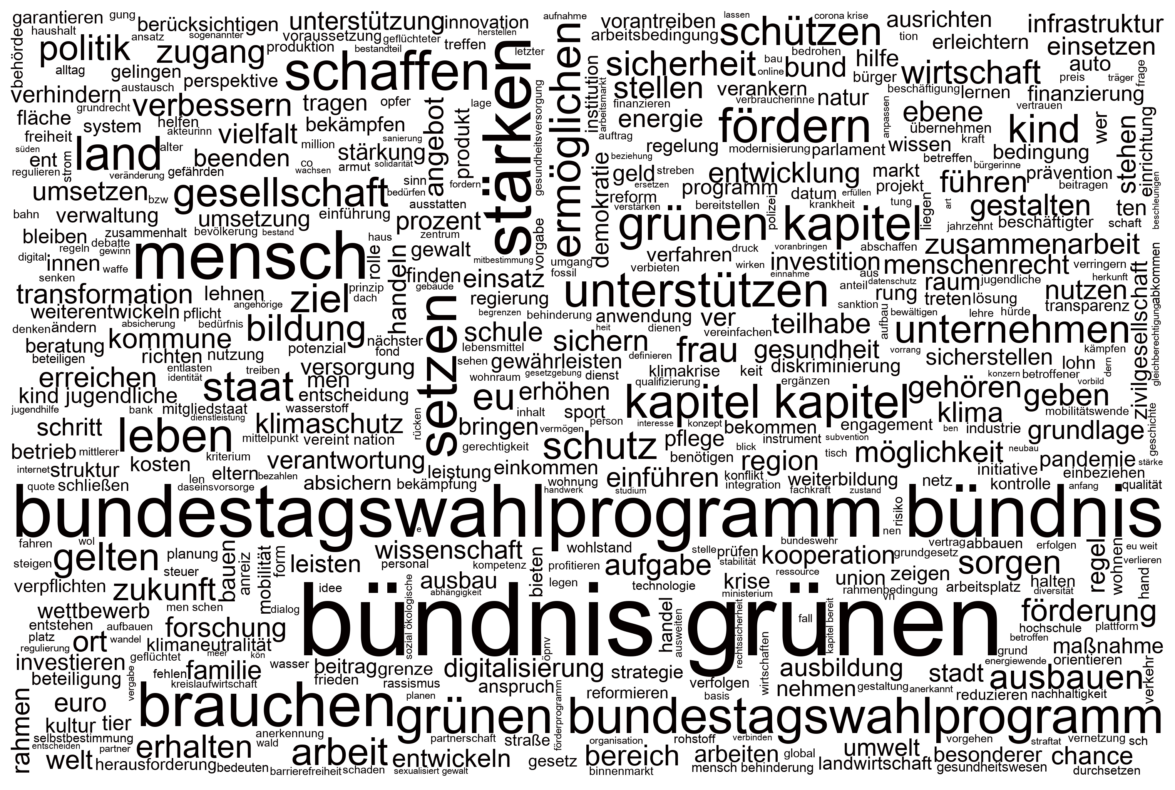

In [38]:
get_word_cloud(words)


In [39]:
[s.replace("#", "   ") for s in sentences if s.startswith("#")]

[]

In [40]:
sentences[0]

'IEITTESALTENTR Alles ist drin'

In [41]:
topical_sentences = get_topical_sentences(sent, topics)


In [42]:
topical_sentences

{'wirtschaft': ['bereit',
  'berlin   telefon   fax e-mail info@gruener',
  '--   v',
  'berlin   layout satz twentyfour seven creative media service gmbh berlin twentyfour-',
  'kg preetz www',
  'eversfrank',
  'fördern kind jugendliche familie',
  'sorgen arbeit fair lohn',
  'enden ära beginnen',
  'rücksichtnahme mensch legen',
  'wis senschaft fortschritt',
  'politik hinauswächst',
  'politik weitblick frieden',
  'gesellschaft schlüssel viele hand',
  'wort reichen',
  'für',
  'reaktiv politik letzter versuchen schlimme verhindern',
  'gute ermöglichen',
  'programm anfang',
  'ständen ebenfalls',
  'lassen gemeinsam politisch arbeit höhe bringen',
  'demo- kratie geliehen',
  'sinn handeln',
  'führen',
  'angebot wer ben mehrheit kommend',
  'laden weg',
  'bereit',
  'gelten ergreifen',
  'folge vervielfachen umsteuern',
  'verlangen mut',
  'bereich wandeln verschwinden',
  'handwerkerin stahlarbeiter',
  'setzen priorität',
  'kapitel',
  'bereit',
  'schützen',
  'zerstö

In [43]:
topic_sentence_count = dict()
for topic in topics:
    topic_sentence_count[topic] = len(topical_sentences[topic])

In [44]:
topic_sentence_count


{'wirtschaft': 1161,
 'Klima': 371,
 'Bildung': 101,
 'Gesundheit': 151,
 'Wissenschaft': 136,
 'soziale Ursachen': 205,
 'Politik und Ideologie': 2102,
 'Infrastruktur': 653}

In [45]:
df_top=get_topical_sentences(sent, topics,1)

In [46]:
df_top['test']=sentences

In [47]:
df_top.head()

,text,topic,test
0,ieittesaltentr,soziale Ursachen,IEITTESALTENTR Alles ist drin
1,bundestagswahlprogramm,Politik und Ideologie,Bundestagswahlprogramm
2,bereit,wirtschaft,"Bereit, weil Ihr es seid"
3,bundestagswahlprogramm bundesdelegiertenkonf...,Politik und Ideologie,Dieses Bundestagswahlprogramm wurde auf der B...
4,herausgeberin bündnis grünen platz tor,Politik und Ideologie,Herausgeberin: BÜNDNIS DIE GRÜNEN Platz vor d...


In [48]:
plot_topical_presence(
    sentences, 
    topics, 
    title=f"Presença de Topics no programa do partido {selected_party.upper()}",
    color=party_data[selected_party]["color"],
)

In [49]:
plot_approaches(sentences, approaches)

In [90]:
import sentencepiece as spm

In [89]:
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer

sentiment_model_path = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer=AutoTokenizer.from_pretrained(sentiment_model_path,use_fast=False)
sentiment_task = pipeline(
    "sentiment-analysis", model=sentiment_model_path, tokenizer=tokenizer
)
sentiment_task("Huggingface es lo mejor! Awesome library 🤗😎")

ValueError: Couldn't instantiate the backend tokenizer from one of: 
(1) a `tokenizers` library serialization file, 
(2) a slow tokenizer instance to convert or 
(3) an equivalent slow tokenizer class to instantiate and convert. 
You need to have sentencepiece installed to convert a slow tokenizer to a fast one.

In [87]:
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer
def get_sentiment(sentences):
    "based on pretrained model try to identify which elements have which sentiment"
    sentiment_model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
    tokenizer=AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment",use_fast=False)
    sentiment_task = pipeline(
        "sentiment-analysis", model=sentiment_model_path, tokenizer=tokenizer
    )
    sentiment_outputs = [
        sentiment_task(sentence)
        for sentence in tqdm(sentences, desc="Sentiment analysis")
    ]
    sentiments_dict = dict(label=[], score=[], sentence=[])
    for idx, output in enumerate(sentiment_outputs):
        sentiments_dict["label"].append(output[0]["label"])
        sentiments_dict["score"].append(output[0]["score"])
        sentiments_dict["sentence"].append(sentences[idx])
    sentiment_df = pd.DataFrame(sentiments_dict)
    sentiment_df["label"] = sentiment_df.label.map(
        dict(Positive="positiv", negative="negativ", Neutral="neutral")
    )
    return sentiment_df


def get_hate_speech(
    sentences, sentiment_df, label_col: str = "label"
):
    "Get the hate speech of a list of sentences."
    
    hate_model_path = "Hate-speech-CNERG/bert-base-uncased-hatexplain"
    hate_task = pipeline(
        "text-classification", model=hate_model_path, tokenizer=hate_model_path
    )
    hate_outputs = [
        hate_task(sentence) for sentence in tqdm(sentences, desc="Hate speech analysis")
    ]
    hate_dict = dict(label=[], score=[], sentence=[])
    for idx, output in enumerate(hate_outputs):
        hate_dict["label"].append(output[0]["label"])
        hate_dict["score"].append(output[0]["score"])
        hate_dict["sentence"].append(sentences[idx])
    hate_df = pd.DataFrame(hate_dict)
    hate_df["label"] = hate_df.label.map(dict(HATE="negativ", NON_HATE="neutral"))
    hate_condition = (hate_df.label == "negativ") & (sentiment_df[label_col] == "negativ")
    hate_df.loc[hate_condition, "label"] = "negativ"
    hate_df.loc[~hate_condition, "label"] = "neutral"
    return hate_df

In [80]:
sentiment_df = get_sentiment(sentences)
sentiment_df

ValueError: Couldn't instantiate the backend tokenizer from one of: 
(1) a `tokenizers` library serialization file, 
(2) a slow tokenizer instance to convert or 
(3) an equivalent slow tokenizer class to instantiate and convert. 
You need to have sentencepiece installed to convert a slow tokenizer to a fast one.

In [ ]:
sentiment_df[sentiment_df.label == "negativ"].sentence.sample(10).values


In [ ]:
sentiment_df[sentiment_df.label == "positiv"].sentence.sample(10).values


In [ ]:
plot_sentiment(sentiment_df)


# Nicht Niclas seins

In [ ]:

def get_topical_sentences_pip(
    sentences, topics
) :
    """
    Get lists of sentences per topic, based on the presence of
    words that are a part of the topic.
    Args:
        sentences (List[str]):
            List of sentences to analyse.
        topics (Dict[str, List[str]]):
            Dictionary of words per topic.
    Returns:
        Dict[str, List[str]]:
            Dictionary of sentences per topic.
    """
    topical_sentences = dict()
    topic_list=[x.lower() for x in list(topics.keys())+['None']]
    for topic in topic_list:
        topical_sentences[topic] = list()
    classifier = pipeline("zero-shot-classification",
                      model="valhalla/distilbart-mnli-12-1")
    for sentence in tqdm(sentences):
        class_sent=classifier(sentence, topic_list)
        topical_sentences[class_sent['labels'][max(range(len(class_sent['scores'])), key=class_sent['scores'].__getitem__)]].append(sentence)
    return topical_sentences

In [ ]:
def plot_topical_presence_nlp_pip(
    sentences: List[str],
    topics:List[str],
    title: str = None,
    color: str = "blue",
    height: int = 300,
) :
    """
    Plot the number of sentences per topic.
    Args:
        sentences (List[str]):
            List of sentences to analyse.
        topics (Dict[str, List[str]]):
            Dictionary of words per topic.
        title (str):
            Title of the plot.
        color (str):
            Color of the bars in the plot.
        height (int):
            Height of the plot.
    Returns:
        Figure:
            Plotly figure with the number of sentences per topic.
    """
    topical_sentences = get_topical_sentences_pip(sentences, topics)
    topic_sentence_count = dict()
    for topic in topical_sentences.keys():
        topic_sentence_count[topic] = len(topical_sentences[topic])
    topic_sentence_count = pd.DataFrame(
        topic_sentence_count, index=["sentence_count"]
    ).T
    topic_sentence_count["sentence_percentage"] = (
        topic_sentence_count["sentence_count"] / len(sentences) * 100
    )
    topic_sentence_count.index.name = "topic"
    topic_sentence_count.sort_index(inplace=True)
    fig = px.bar(topic_sentence_count, x="sentence_percentage", orientation="h")
    fig.update_layout(
        title=title,
        xaxis_title="Percentagem de frases topicais no texto",
        yaxis_title="Topic",
        yaxis=dict(categoryorder="category descending"),
        margin=dict(l=0, r=0, b=0, t=0, pad=0),
        height=height,
    )
    fig.update_traces(marker_color=color)
    return fig

In [ ]:
get_topical_sentences_pip(sentences, topics)

Downloading:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/890M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

  0%|          | 0/4880 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plot_topical_presence_nlp_pip(
    sentences, 
    topics, 
    title=f"Presença de Topics no programa do partido {selected_party.upper()}",
    color=party_data[selected_party]["color"],
)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
  0%|          | 0/4880 [00:07<?, ?it/s]


KeyError: 'Infrastruktur'

In [ ]:
sequence = "Die Wirtschaft verlief gut"


a=classifier(sequence, list(topics.keys()), multi_label=True)

In [ ]:
%%time

a['labels'][max(range(len(a['scores'])), key=a['scores'].__getitem__)]

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 8.82 µs


'wirtschaft'

In [ ]:
a

{'sequence': 'Die Wirtschaft verlief gut',
 'labels': ['wirtschaft',
  'Klima',
  'soziale Ursachen',
  'Infrastruktur',
  'Bildung',
  'Gesundheit',
  'Wissenschaft',
  'Politik und Ideologie'],
 'scores': [0.9855690002441406,
  0.19884544610977173,
  0.09111900627613068,
  0.0037139991763979197,
  0.0007422503549605608,
  0.0007094655302353203,
  0.0002491624909453094,
  5.607574712485075e-05]}